Курс DST-PRO
Проект 3
Цель: Проанализировать данные о рестаранах с сайта Tripadvisor.com для создания модели прогнозирования рейтинга ресторанов
Задачи:
1. Проанализировать исходный датасет
2. Загрузить дополнительные данные из веншних источников
3. Произвести очистку данных
4. Сформировать дополнительные признаки из имеющихся
5. Сформировать данные для обучения модели
6. Обучить модель
7. Произвести оценку полученного результата

# Загрузка Pandas и очистка данных

In [151]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import plotly.express as px
from pprint import pprint
from bs4 import BeautifulSoup
from selenium import webdriver
import requests
import re
import json
from math import radians, cos, sin, asin, sqrt, degrees, pi, atan2

# Расширяем диапазон отображаемых данных.
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

In [152]:
# Загружаем данные
df = pd.read_csv('main_task_new.csv')

In [153]:
# Посмотрим на структуру данных
df.head()

Restaurant_id       City                                      Cuisine Style  \
0       id_5569      Paris            ['European', 'French', 'International']   
1       id_1535  Stockholm                                                NaN   
2        id_352     London  ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...   
3       id_3456     Berlin                                                NaN   
4        id_615     Munich  ['German', 'Central European', 'Vegetarian Fri...   

   Ranking  Rating Price Range  Number of Reviews  \
0   5570.0     3.5    $$ - $$$              194.0   
1   1537.0     4.0         NaN               10.0   
2    353.0     4.5        $$$$              688.0   
3   3458.0     5.0         NaN                3.0   
4    621.0     4.0    $$ - $$$               84.0   

                                             Reviews  \
0  [['Good food at your doorstep', 'A good hotel ...   
1  [['Unique cuisine', 'Delicious Nepalese food']...   
2  [['Catch up with friends', 'Not exceptional'],...   
3                                           [[], []]   
4  [['Best place to try a Bavarian food', 'Nice b...   

                                              URL_TA     ID_TA  
0  /Restaurant_Review-g187147-d1912643-Reviews-R_...  d1912643  
1  /Restaurant_Review-g189852-d7992032-Reviews-Bu...  d7992032  
2  /Restaurant_Review-g186338-d8632781-Reviews-RO...  d8632781  
3  /Restaurant_Review-g187323-d1358776-Reviews-Es...  d1358776  
4  /Restaurant_Review-g187309-d6864963-Reviews-Au...  d6864963

Итак, данные загружены без ошибок, стоблбцы софрмированы. Видно что есть как числовые значения. так и текостовые.
Для дальнейшего анализа посмотрим подбробнее на типы данных, также посмотрим в каком виде прдеставленны списки - в готовом или посто текстовом

In [154]:
# Посмотрим на типы загруженных данных
df.info()
type(df['Cuisine Style'].iloc[0]) # Определим что хранится в столбце со стилями кухонь - готовый список или нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


str

Видно, что имеются числовые признаки рейтинга (ключевой признак), рагна ресторана, и количества отзывов. Все остальные признаки не в числовом виде
Списки представленны в виде строки и требуют преборазования
В данных имеются пропуски, ольше всего в столбце ценового уровня ресторана

Следующи шагом оценим количество дубликатов
У нас есть два подходящих для этого признака: ИД ресторана и ИД трипадвизора

In [155]:
print(df.Restaurant_id.duplicated().sum()) # Дубликаты по Id ресторана
print(df.URL_TA.duplicated().sum()) # Дубликаты по Id трипадвизора

28091
20


Дубликатов по столбцу ИД ресторана очень много, нужно более подробно рассмотреть этот признак

In [156]:
# Отобразим дубликаты по ИД ресторана
display(df[df.Restaurant_id.duplicated()].head())

Restaurant_id       City  \
174       id_2044   Budapest   
193          id_8  Ljubljana   
201         id_72   Brussels   
216       id_2273     Vienna   
271        id_773     Vienna   

                                         Cuisine Style  Ranking  Rating  \
174                                        ['Italian']   2045.0     3.5   
193  ['European', 'Central European', 'Vegetarian F...      9.0     4.5   
201  ['Belgian', 'European', 'International', 'Vege...     73.0     4.0   
216                                                NaN   2275.0     4.5   
271  ['Austrian', 'European', 'Central European', '...    774.0     4.0   

    Price Range  Number of Reviews  \
174         NaN                5.0   
193    $$ - $$$              816.0   
201    $$ - $$$              779.0   
216         NaN                2.0   
271        $$$$               67.0   

                                               Reviews  \
174                                           [[], []]   
193  [['Casual chic restaurant!', 'Good but a littl...   
201  [['Delicious', 'They dealt with the problems v...   
216                                           [[], []]   
271  [['Very nice dinner 👌', 'unique style'], ['02/...   

                                                URL_TA      ID_TA  
174  /Restaurant_Review-g274887-d10498197-Reviews-P...  d10498197  
193  /Restaurant_Review-g274873-d8124300-Reviews-Ro...   d8124300  
201  /Restaurant_Review-g188644-d4014123-Reviews-Ab...   d4014123  
216  /Restaurant_Review-g190454-d11903856-Reviews-G...  d11903856  
271  /Restaurant_Review-g190454-d5976718-Reviews-Re...   d5976718

Возьмем к примеру один из списков дубликатов по id_2044

In [157]:
# Посмотрим для примера все рестораны с ИД 2044
display(df[df.Restaurant_id=='id_2044'])

Restaurant_id       City  \
140         id_2044  Barcelona   
174         id_2044   Budapest   
3030        id_2044     London   
20646       id_2044     Vienna   
20653       id_2044  Stockholm   
23141       id_2044     Warsaw   
31384       id_2044     Lisbon   
32334       id_2044      Paris   

                                           Cuisine Style  Ranking  Rating  \
140                         ['Italian', 'Mediterranean']   2045.0     4.5   
174                                          ['Italian']   2045.0     3.5   
3030   ['Asian', 'Thai', 'Vegetarian Friendly', 'Vega...   2048.0     4.5   
20646                                                NaN   2046.0     4.5   
20653                                                NaN   2047.0     3.5   
23141                                                NaN   2046.0     3.0   
31384                                                NaN   2047.0     5.0   
32334                            ['Vegetarian Friendly']   2045.0     4.5   

      Price Range  Number of Reviews  \
140      $$ - $$$               89.0   
174           NaN                5.0   
3030     $$ - $$$               75.0   
20646         NaN                7.0   
20653         NaN                2.0   
23141         NaN                5.0   
31384         NaN                NaN   
32334    $$ - $$$              118.0   

                                                 Reviews  \
140    [['Real Sicilian cuisine', 'A really nice surp...   
174                                             [[], []]   
3030   [['Hidden up a little alley ....', 'Best ribs'...   
20646  [['Bio taste', 'Perfect to begin the day!'], [...   
20653  [['OK coffee', 'A lucky find of great coffee']...   
23141                 [['Beef in Thai'], ['04/04/2017']]   
31384                                           [[], []]   
32334  [['A very nice place for a brunch', 'Really go...   

                                                  URL_TA      ID_TA  
140    /Restaurant_Review-g187497-d8118086-Reviews-Or...   d8118086  
174    /Restaurant_Review-g274887-d10498197-Reviews-P...  d10498197  
3030   /Restaurant_Review-g186338-d11838055-Reviews-S...  d11838055  
20646  /Restaurant_Review-g190454-d8811567-Reviews-Ka...   d8811567  
20653  /Restaurant_Review-g189852-d9702108-Reviews-Ol...   d9702108  
23141  /Restaurant_Review-g274856-d10046967-Reviews-C...  d10046967  
31384  /Restaurant_Review-g189158-d13298844-Reviews-M...  d13298844  
32334  /Restaurant_Review-g187147-d8439753-Reviews-Le...   d8439753

По полученному результату видно, что данные отнюдь не походи на дубликаты, также они явно не относятся даже к одной сети, а соответственно признако ИД ресторана в дальнейшем можно отбросить и не учитывать, т.к. не несет никакой информации
ИД трападвизора же имеет всего 20 дубликатов, пожтому его и будем испольовать для однозначной идентификации ресторанов

Следующим шаго осуществим подгрузку данных из внешних источников.
Первым источником будет непсредственно сайт трипадвизора, ссылка на страницу которого у нас имеется в исходном датасете

In [158]:
# Загрузим необходимые библиотеки для парсинга веб страниц

# from selenium.webdriver.firefox.options import Options

# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support import expected_conditions as EC

# chrome_options = Options()
# chrome_options.add_argument('--no-sandbox')
# chrome_options.add_argument('--headless')
# chrome_options.add_argument('--disable-extensions')
# chrome_options.add_argument("--disable-dev-shm-usage");
# driver = webdriver.Firefox(options=chrome_options)


По итогу в ходе парсинга возникли проблеммы - парсинг одной страницы длился порядка 3,5 секунд и несколько замедлялся после 20000 распасреных страниц.
На полный парсинг необходимо было около 2х суток непрерывной работы скрипта.
На первом прохождении возник собй, скрипт вылетел после суток работы и данные поетрялись. Было принято решение созранять данные одтельными порциями по 100 записей по отдельным файлам, с последующим их объединением, чтобы избежать потери данных из-за собев.
В итоге весь парсинг от первого прохода, до получения итогового результата занял около 5 дней (OMG).
Код парсинга, после получения итогового результата был закоментирован, а данные созранены в отдельный файл, который при последующей работе и загружался

In [159]:
# Фрагмент кода для подсчета уже загруженных данных, формирование списка файлов и задания индекса для следующего загружаемого файла
# from os import listdir
# from os.path import isfile, join
# onlyfiles = [f for f in listdir('.') if isfile(join('.', f))]
# onlyfiles = [x for x in onlyfiles if 'restr' in x]
# n_str_list = [x.split('ts')[1].split('.')[0] for x in onlyfiles]
# n_str_list.remove('')
# n_str_list.remove('_001')
# n_str_list.remove('_002')
# num = np.max(([int(x) for x in n_str_list if x!='']))
# num

In [160]:

# Код непсредственного парсинга страниц
# Первоначально загружали ранее созраненные данные, дабы не парсить их по второму разу.
# restraunts = pd.DataFrame()
# prev_rest = None
# for f in onlyfiles:
#     if prev_rest is None:
#         prev_rest = pd.read_csv(f,sep=';')
#     else:
#         temp_restr = pd.read_csv(f,sep=';')
#         prev_rest = prev_rest.append(temp_restr,ignore_index=True)

# file_n = num
# for i, r in df[~df['ID_TA'].isin(prev_rest['ID_TA'])].iterrows():
#     file_n+=1
#     if file_n%100 ==0:
#         restraunts.to_csv('restraunts'+str(file_n) + '.csv',sep=';',index=False) # Сохраняем данные загруженных ресторанов в отдельные файлы по 100 ресторанов в каждом
#         restraunts = pd.DataFrame()
#     if i%10 == 0:
#         print(i)
#     #try:
#     driver.get('https://www.tripadvisor.com'+r['URL_TA'])
#     html = driver.page_source
#     soup = BeautifulSoup(html)
    
#     over_rank = soup.find('a',{'class':'fhGHT'})
#     rank=None
#     if over_rank:
#         over_rank = over_rank.span.text.replace(',','').split(" of ")
#         rank = re.search(r'(\d+)',over_rank[0])
#         if len(over_rank)>1:
#             over_rank = re.search(r'(\d+)',over_rank[1])
#     if rank:
#         rank = int(rank.group(0))
#     try:
#         if over_rank and type(over_rank)!='<class \'list\'>' or '<class \'str\'>':
#             over_rank = int(over_rank.group(0))
#     except:
#         over_rank=None
#     reviews_cnt = soup.find('span',{'class':'eBTWs'})
#     if reviews_cnt:
#         reviews_cnt = int(reviews_cnt.text.split(' ')[0].replace(',',''))
    
#     price_cuisines = soup.find_all('a', {'class':'drUyy'})
#     cuisines=set()
#     price = None
#     if price_cuisines:
#         for it in price_cuisines:
#             if re.search(r'\$',it.text):
#                 price = it.text.strip()
#             else:
#                 cuisines.add(it.text.strip())
#     specials = soup.find_all(attrs={'class':'cfvAV'})
#     specials_headers = soup.find_all(attrs={'class':'dMshX b'})
#     price_max = None
#     price_min = None
#     price_range = None
#     diets=[]
#     if specials_headers:
#         for i, val in enumerate(specials_headers):
#             if val.text == "PRICE RANGE":
#                 price_range = specials[i].text.replace('RUB','').replace(',','')
#             elif val.text == "CUISINES":
#                 cus_tmp = []
#                 c_t = specials[i].text.split(',')
#                 for c in c_t:
#                     cus_tmp.append(c.strip())
#             elif val.text == "Special Diets":
#                 diets=[]
#                 diets_tmp = specials[i].text.split(',')
#                 for d in diets_tmp:
#                     diets.append(d.strip())
#     if cus_tmp:
#         cuisines.update(cus_tmp)
#     if diets:
#         cuisines.update(diets) 
#     if price_range:
#         tmp = price_range.split('-')
#         if len(tmp)>1:
#             price_min=int(tmp[0])
#             price_max=int(tmp[1])
#             price_range=price_max-price_min

#     scripts = soup.find_all('script')
#     for s in scripts:
#         if s.find(text=re.compile("window.__WEB_CONTEXT__=")):
#             to_parse = s
#             break
#     parse_hours = re.search(r'"week_ranges":.*"timezone"',str(to_parse))
#     time_break = 0
#     if parse_hours:
#         hours = []
#         for day in json.loads('{'+parse_hours.group(0)+r':0}')['week_ranges']:
#             h_cnt = 0
#             if not time_break:
#                 if len(day)>1:
#                     time_break=1
#             for h in day:
#                 h_cnt+=(h['close_time']-h['open_time'])/60
#             hours.append(h_cnt)
#     else:
#         hours = None
#     if hours:
#         work_day_in_week = len(hours)
#         hours = np.mean(hours)
#     else:
#         work_day_in_week = None
    
#     location = re.search(r'"latitude":(\d*\.\d*),"longitude":(\d*\.\d*),', str(to_parse))
#     if location:
#         latitude = float(location.group(1))
#         longitude = float(location.group(2))
#     else:
#         latitude = None
#         longitude = None
    
#     new_row = {
#         'ID_TA':r['ID_TA'], # ИД трипадвизора
#         'cuisines':cuisines, # список кухонь
#         'price':price, # ранг рестарана по цене
#         'price_min':price_min, # минимальная цена
#         'price_max':price_max, # максимальная цена
#         'price_range':price_range, # разброс цен
#         'work_hours':hours, # кол-во рабочих часов в сутки
#         'time_break':time_break, # колличество перерывов в день
#         'work_day_in_week':work_day_in_week, # количество рабочих дней в неделю
#         'latitude':latitude, # Широта ресторана
#         'longitude':longitude, # Долгота ресторана
#         'rank':rank, # Ранг ресторана
#         'over_rank':over_rank, # Количество всего ранжированных ресторанов
#         'reviews_cnt':reviews_cnt, # Количество отзывов
        
#     }
#     restraunts = restraunts.append(new_row,ignore_index=True)
         
# restraunts

In [161]:
# Сохраним последнюю группу ресторанов
# restraunts.to_csv('restraunts_002.csv',sep=';',index=False)

In [162]:
# Загрузим все рестораны в один датафрейм

# restraunts=pd.read_csv('restraunts.csv',sep=';')

# for f in onlyfiles:
#     if f != 'restraunts.csv':
#         temp_restr = pd.read_csv(f,sep=';')
#         restraunts = restraunts.append(temp_restr,ignore_index=True)

In [163]:
# Почистим от дубликатов
# restraunts.drop_duplicates(inplace=True)
# restraunts.shape

In [164]:
# Сохраним объединенный датасет с ресторанами в отдельный файл для последующего использования
# restraunts.to_csv('restraunts_final.csv',sep=';',index=False)

In [165]:
# Загрузим данные ресторанов из файла с обобщенным датасетом
restraunts = pd.read_csv('restraunts_final.csv',sep=';')
restraunts.shape

(39989, 14)

Итак, файл готов, при отчистке от дубликатов остается 399989 записей.

Теперь загрузим данные под городам, в которых расположены рестораны.
В качестве источника используем Википедию
Т.к. городов намного меньше чем самих ресторанов, шаманство в виде созранения отдельными порциями нам не поднадобилось, загруденны данные в один прием и также созранены в отдельный файл, чтобы не тратить время на парсинг при каждом перезапуске ноутбука. Сам код парсинга при этом закоментирован

In [166]:
# city_list = df.groupby('City').count().index
# city_data = pd.DataFrame()
# pattern = re.compile(r'(\d+\.?\d*)')
# coord_names = ['deg','min','sec']
# for city in city_list:
#     response = requests.get(r'https://en.wikipedia.org/wiki/'+city)
#     if response.status_code==200:
#         latitude = None
#         longitude = None
#         page = BeautifulSoup(response.text)
        
#         latitude_deg = page.find(attrs={'class':'latitude'})
#         if latitude_deg:
#             coord = {'deg':0,'min':0,'sec':0,'dir':1}
#             if latitude_deg:
#                 coord['dir'] = -1 if latitude_deg.text[-1] == 'S' else 1
#                 latitude_deg = re.findall(pattern,latitude_deg.text)
#                 for i, val in enumerate(latitude_deg):
#                     coord[coord_names[i]]=float(val)
#                 latitude = coord['dir']*(coord['deg'] + coord['min']/60 + coord['sec']/3600)
#         longitude_deg = page.find(attrs={'class':'longitude'})
#         if longitude_deg:
#             coord = {'deg':0,'min':0,'sec':0,'dir':1}
#             if longitude_deg:
#                 coord['dir'] = -1 if longitude_deg.text[-1] == 'E' else 1
#                 longitude_deg = re.findall(pattern,longitude_deg.text)
#                 for i, val in enumerate(longitude_deg):
#                     coord[coord_names[i]]=float(val)
#                 longitude = coord['dir']*(coord['deg'] + coord['min']/60 + coord['sec']/3600)

#         info_table = page.find(attrs={'class':'infobox'}).find_all('tr')
#         area = None
#         population = None
#         for i, tr in enumerate(info_table):
#             th = tr.find('th')
#             if th:
#                 if 'Area' in th.text and not ('rank' in th.text or 'code' in th.text) and not area:
#                     if info_table[i].find('td'):
#                         area = re.match(r'\d+\.?\d*',info_table[i].find('td').text.replace(',',''))
#                         if area:
#                             area = float(area.group(0))
#                     else:
#                         area = re.match(r'\d+\.?\d*',info_table[i+1].find('td').text.replace(',',''))
#                         if area:
#                             area = float(area.group(0))
#                 if 'Population' in th.text and not population:
#                     if info_table[i].find('td'):
#                         population = re.match(r'\d+\.?\d*',info_table[i].find('td').text.replace(',',''))
#                         if population:
#                             population = float(population.group(0))
#                     else:
#                         population = re.match(r'\d+\.?\d*',info_table[i+1].find('td').text.replace(',',''))
#                         if population:
#                             population = float(population.group(0))
#                         else:
#                             pop = info_table[i+1].find('td').text.replace(',','')
#                             population = float(pop[:7])
#                     if population and population<100000:
#                         for j in range(1,5):
#                             pop_tr = info_table[i+j]
#                             pop_th = pop_tr.find('th')
#                             if pop_th:
#                                 if 'Density' in pop_th.text:
#                                     dens = float(pop_tr.find('td').text.replace(',','').split('/km2')[0])
#                                     if area:
#                                         population = area * dens
#                                     break
                            
#         daily_mean_temp = None
#         climate_table = page.find(attrs={'class':'wikitable'})
#         if climate_table:
#             tr_list = climate_table.find_all('tr')
#             if tr_list:
#                 for tr in tr_list:
#                     th = tr.find('th')
#                     if th:
#                         if 'Daily mean' in th.text:
#                             td_list = tr.find_all('td')
#                             if td_list:
#                                 temperature = td_list[-1].text
#                                 daily_mean_temp = float(temperature.split('(')[0])
#         city_clim_dict = {
#             'Luxembourg':9.95,
#             'Oslo':6.09,
#             'Vienna':11.98,
#             'Zurich':11.17
#         }
#         if not daily_mean_temp:
#             daily_mean_temp = city_clim_dict[city]
            
#         new_city = {
#             'city':city, # Название города
#             'latitude':latitude, # Широта города 
#             'longitude':longitude, # Долгота города
#             'area':area, # Площадь города
#             'population':population, # Население города
#             'daily_mean_temp':daily_mean_temp # Среднедневная температура в городе 
#         }
#         city_data = city_data.append(new_city,ignore_index=True)

# city_data


In [167]:
# Сохраним скачанные данные по городам
# city_data.to_csv('cities.csv',sep=";",index=False)

Итак данные по ресторанам и городам загружены, созранены, теперь объединим изх с исходным жатасетом

In [168]:
# Загрузим данные по городам из сохраненного ранее датасета
city_data = pd.read_csv('cities.csv',sep=';')

In [169]:
# Соединим основной датасет с данными по ресторанам с трипадвизора
df = df.merge(right=restraunts,how='left',on='ID_TA')

In [170]:
# Проверим дубликаты по ИД трипадвизора
df['ID_TA'].duplicated().sum()

38

In [171]:
# Удалим дубликаты
df = df.drop_duplicates(subset=['ID_TA'])
df.shape

(39980, 23)

In [172]:
# Добавим данные по городам
df = df.merge(right=city_data,left_on='City', right_on='city', suffixes=('','_city'),how='left')

In [173]:
# Посмотрим что пролучилось
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39979
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      39980 non-null  object 
 1   City               39980 non-null  object 
 2   Cuisine Style      30701 non-null  object 
 3   Ranking            39980 non-null  float64
 4   Rating             39980 non-null  float64
 5   Price Range        26101 non-null  object 
 6   Number of Reviews  37437 non-null  float64
 7   Reviews            39980 non-null  object 
 8   URL_TA             39980 non-null  object 
 9   ID_TA              39980 non-null  object 
 10  cuisines           39980 non-null  object 
 11  price              22491 non-null  object 
 12  price_min          8578 non-null   float64
 13  price_max          8578 non-null   float64
 14  price_range        8578 non-null   float64
 15  work_hours         18542 non-null  float64
 16  time_break         399

Ура! Все получилось. Данные объединены. Можно работать дальше. 
Приступаем к анализу того что есть

In [174]:
# Посмотрм на столбец количества рабочмих дней в неделю
df.work_day_in_week.value_counts()

7.0    18542
Name: work_day_in_week, dtype: int64

In [175]:
# Поскольку у всех ресторанов этот показатель одинаков, то удалим его
df = df.drop('work_day_in_week', axis=1)

In [176]:
# Также оценим и признак количества рабочих часов в день
df.work_hours.value_counts()

12.000000    746
11.000000    509
6.000000     414
10.000000    366
13.000000    362
            ... 
13.678571      1
10.952381      1
4.964286       1
6.852381       1
7.816667       1
Name: work_hours, Length: 655, dtype: int64

In [177]:
# Построим коробчатую диаграмму распределения рабочих часов ресторанов
fig = px.box(df,x='work_hours')
fig.update_layout(
    title = 'work_hours boxplot',
    width = 1000,
    height = 400)
fig.show()

При аналие распределения видно, что имеются явные выбросы - количество часов работы врятли может быть 3 и меньше часов и точно не может быть более 24 часов.
Произведенм очистку данных по этому признаку

In [178]:
work_hours_mode = df.work_hours[df.work_hours>0].mode()[0] # Сохраним моду значений рабочих часов, для замены пропусков и неправильных значений
# Производим операцию над всем столбцом - если значение больше 3 (врятли есть рестораны которые действительно так мало работают) и меньше или равно 24 (больше всеравно частов в сутках нет) то оставим как есть, если нет, то заменим модой
df.work_hours = df.work_hours.apply(lambda x: x if x>3 and x <=24 else work_hours_mode)

In [179]:
display(df.work_hours.describe())
# Отобразим коробчатую диаграмму распределения рабочих часов после коррекции
fig = px.box(df,x='work_hours')
fig.update_layout(
    title = 'work_hours boxplot after cleaning',
    width = 1000,
    height = 400)
fig.show()

count    39980.000000
mean        11.053569
std          2.799196
min          3.035714
25%         10.357143
50%         12.000000
75%         12.000000
max         24.000000
Name: work_hours, dtype: float64

данные по рабочим часам отчищены.

Теперь из имеющихся координат центров городов и координат ресторанов вычислим расстояние до центра города.

In [180]:
# Вычислим расстояние до центра города по формуле с учетом радиуса земли
df['distance_to_city_center'] = 2 * 6371.0088 * np.arcsin(np.sqrt(
    np.sin((np.radians(np.abs(df['latitude']))-np.radians(np.abs(df['latitude_city'])))*0.5)**2 
    + np.cos(np.radians(np.abs(df['latitude']))) * np.cos(np.radians(np.abs(df['latitude_city'])))
    * np.sin((np.radians(np.abs(df['longitude']))-np.radians(np.abs(df['longitude_city'])))*0.5)**2))

In [181]:
print(df.distance_to_city_center.describe())
fig = px.box(df,x='distance_to_city_center')
fig.update_layout(
    title = 'distance_to_city_center boxplot',
    width = 1000,
    height = 400)
fig.show()

count    19076.000000
mean         3.477436
std          8.843972
min          0.001476
25%          1.212612
50%          2.297918
75%          4.007131
max        674.781093
Name: distance_to_city_center, dtype: float64


Во вновь созданном признаке явно есть выбросы - расстояние до центра города более 50 км врятли может быть
Пометим эти данные как пропуски

In [182]:
df.distance_to_city_center = df.distance_to_city_center.apply(
    lambda x: np.NaN if pd.isna(x) else x if x<=50 else np.NaN
)

# Выведем данные по очищеному признаку
print(df.distance_to_city_center.describe())
fig = px.box(df,x='distance_to_city_center')
fig.update_layout(
    title = 'distance_to_city_center boxplot',
    width = 1000,
    height = 400)
fig.show()

count    19061.000000
mean         3.308632
std          3.665564
min          0.001476
25%          1.212310
50%          2.296737
75%          3.999830
max         49.793835
Name: distance_to_city_center, dtype: float64


Вот, теперь распределение имеет более красивый вид и потеряно всего 15 значений

Продолжим анализ данных, следющим признаком возьмем ценовой диапазон.
У нас имеется два столбца с этим признаком из исходных данных и из загруженныз с сайта трипадвизор, посмотрим можно ли скомпенсировать часть пропусков объединив этим признаки

In [183]:
# Посмотрим на суммарное количество пропусков по ценовому рангу в исходных и загруженных данных
(df['Price Range'].isna() & df['price'].isna()).sum()

8929

В результате объединения видно, что количество пропусков при объедиинении меньше, чем в каждом из этих признаков в отдельности.
Поэтому объединим их и приобразуем в числовой вид

In [184]:
# Обьединим данные по ценовому рангу в один столбец
df['Price Range'] = df.apply(lambda row: row['price'] if pd.isna(row['Price Range']) else row['Price Range'],axis=1)
# Преобразуем их в числовой вид
df['Price Range'] = df['Price Range'].apply(lambda x: 0 if x == '$' else 1 if x =='$$ - $$$' else 2 if x == '$$$$' else np.nan)
# посмотрим что получилось
df['Price Range'].describe()

count    31051.000000
mean         0.779170
std          0.519283
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: Price Range, dtype: float64

Отлично. Признак преобразован, аномальных значений нет.

Следующим шагом заполним признаки с пропусками, значения которых отличаются в зависимости от того города в котором находится ресторан.

In [185]:
# Создадим словарь для хранения информации о среднем значении показателей по городам
cities_variables = {
    'price_r':{},
    'distance_to_center':{},
    'over_rank':{}
}
# Создадим переменную для хранения медианного значения отношения расстояния от ресторана до центра города с площадью города
dist_area_ratio = (df['distance_to_city_center']/df['area']).median()
print(dist_area_ratio)

# В цикле заполним значения по каждому городу в словарь
for c in df.groupby('City').count().index:
    cities_variables['price_r'][c] = df['Price Range'][df['City']==c].mode()[0]
    cities_variables['distance_to_center'][c] = df.distance_to_city_center[df['City']==c].median()
    if np.isnan(cities_variables['distance_to_center'][c]):
        cities_variables['distance_to_center'][c] = city_data['area'][city_data.city==c].mean()*dist_area_ratio
    cities_variables['over_rank'][c] = df.over_rank[df.City==c].mode()[0]
cities_variables

0.009873251527585144


{'price_r': {'Amsterdam': 1.0,
  'Athens': 1.0,
  'Barcelona': 1.0,
  'Berlin': 1.0,
  'Bratislava': 1.0,
  'Brussels': 1.0,
  'Budapest': 1.0,
  'Copenhagen': 1.0,
  'Dublin': 1.0,
  'Edinburgh': 1.0,
  'Geneva': 1.0,
  'Hamburg': 1.0,
  'Helsinki': 1.0,
  'Krakow': 1.0,
  'Lisbon': 1.0,
  'Ljubljana': 1.0,
  'London': 1.0,
  'Luxembourg': 1.0,
  'Lyon': 1.0,
  'Madrid': 1.0,
  'Milan': 1.0,
  'Munich': 1.0,
  'Oporto': 1.0,
  'Oslo': 1.0,
  'Paris': 1.0,
  'Prague': 1.0,
  'Rome': 1.0,
  'Stockholm': 1.0,
  'Vienna': 1.0,
  'Warsaw': 1.0,
  'Zurich': 1.0},
 'distance_to_center': {'Amsterdam': 1.5443819569507191,
  'Athens': 1.403374139405714,
  'Barcelona': 2.449143258226118,
  'Berlin': 4.548870634677467,
  'Bratislava': 1.331522370043991,
  'Brussels': 2.568821950526341,
  'Budapest': 1.6260534498707162,
  'Copenhagen': 1.4530864566720592,
  'Dublin': 1.1630690299495299,
  'Edinburgh': 2.606538403282478,
  'Geneva': 1.0222477178431506,
  'Hamburg': 3.0638455558646687,
  'Helsinki':

In [186]:
# Функция для заполнения пропусков в признаках 
def update_rest_info_for_city(row):
    if pd.isna(row['Price Range']):
        row['Price Range'] = cities_variables['price_r'][row['City']]
    if pd.isna(row['distance_to_city_center']):
        row['distance_to_city_center'] = cities_variables['distance_to_center'][row['City']]
    if pd.isna(row['over_rank']):
        row['over_rank'] = cities_variables['over_rank'][row['City']]
    return row

# Применим функцию к датасету
df = df.apply(update_rest_info_for_city,axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39979
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            39980 non-null  object 
 1   City                     39980 non-null  object 
 2   Cuisine Style            30701 non-null  object 
 3   Ranking                  39980 non-null  float64
 4   Rating                   39980 non-null  float64
 5   Price Range              39980 non-null  float64
 6   Number of Reviews        37437 non-null  float64
 7   Reviews                  39980 non-null  object 
 8   URL_TA                   39980 non-null  object 
 9   ID_TA                    39980 non-null  object 
 10  cuisines                 39980 non-null  object 
 11  price                    22491 non-null  object 
 12  price_min                8578 non-null   float64
 13  price_max                8578 non-null   float64
 14  price_range           

3-и признака успешно отчищены от пропусков.

У нас есть признак цены,
Созаним признак среднего чека

In [187]:
# Создаем новый признак среднего чека как полусумму минимального и максимального чека
df['price_mean'] = (df.price_max+df.price_min)/2

# Построим коробчатую диаграмма распредления значений среднего чека
fig = px.box(df,x='price_mean')
fig.update_layout(
    title = 'price mean value boxplot',
    width = 1000,
    height = 400)
fig.show()

При анализе распределения видны отчетивые выбросы по среднему чеку в 30 и более тыся рублей (такие рестораны несмненно могут существовать, но в анализе эти цифры будут мешать, поэтому все ценники выше 30000 установим в 30 тр и цены меньше 200 рублей в 200 (ну вретли в европе можно найти даже маленькую кофейню с ценником ниже))

In [188]:
# Произведем коррекцию признака среднего чека - отсечем значения более 30000 и устновим их в 30000 как максимальный чтобы сгладить распределение
df.price_mean = df.price_mean.apply(lambda x: 30000 if x > 30000 else np.nan if pd.isna(x) else 200 if x<200 else x)
# словарь для хранения медианного начения среднего чека в зависимости от ценовой категории ресторана
price_mean_median_for_price_range = {}
# Заполним словарь в цикле
for pr in df.groupby('Price Range').count().index:
    price_mean_median_for_price_range[pr] = df.price_mean[df['Price Range']==pr].median()
# Заполним пропуски, значениями из созданного словаря
df['price_mean'] = df.apply(lambda row: row['price_mean'] if ~pd.isna(row['price_mean']) else price_mean_median_for_price_range[row['Price Range']], axis=1)
fig = px.box(df,x='price_mean')
fig.update_layout(
    title = 'price mean value boxplot',
    width = 1000,
    height = 400)
fig.show()

Т.к. признак ранга заведений по разным городам может различаться, то лучше универсализировать его, создав новый признак относительного ранга заведения, поделив ранг на колличество заведений в городе.

In [189]:
# Создадим новый признак относительного ранга заведния, чтобы выровнять значения без относительно численности заведения в городе 
# (200 из 1000 выше в рейтинге чем 25 из 100)
df['relative_ranking'] = df.Ranking/df.over_rank

In [190]:
# Заполним пропуски в признаке числа отзывов
df['Number of Reviews'] = df['Number of Reviews'].fillna(0)

Итак, уже набралось достатоное количество числовых признаков, чтобы произвести оценку их взаимосвязи с ключевым признаком, для этого в цикле проверим кореляцию спирмана по каждому числовому признаку

In [191]:
# дополнительно импортируем необходимую библиотечную функцию
from scipy.stats import spearmanr as sp

# Произведем перебор в цикле всех числовых признаков
for col in df.columns:
    if df[col].dtype != 'object':  # не будем включать текстовые
        print(col+': ')
        # Используем функцию с параметром nan_policy='omit' для игнорирования пропущенных значений.
        display(sp(df[col], df['Rating'], nan_policy='omit'))

Ranking: 


SpearmanrResult(correlation=-0.34184700049334155, pvalue=0.0)

Rating: 


SpearmanrResult(correlation=1.0, pvalue=0.0)

Price Range: 


SpearmanrResult(correlation=-0.028884618154761104, pvalue=7.626877907886385e-09)

Number of Reviews: 


SpearmanrResult(correlation=-0.07651499036515669, pvalue=5.522602477996277e-53)

price_min: 


SpearmanrResult(correlation=-0.1351940937347838, pvalue=2.8151041729109684e-36)

price_max: 


SpearmanrResult(correlation=-0.09973581023106702, pvalue=2.0630289448540872e-20)

price_range: 


SpearmanrResult(correlation=-0.035543900874636866, pvalue=0.0009928410328183894)

work_hours: 


SpearmanrResult(correlation=-0.12901791092788129, pvalue=5.9026311056243944e-148)

time_break: 


SpearmanrResult(correlation=0.03712527284820607, pvalue=1.123329054255728e-13)

latitude: 


SpearmanrResult(correlation=-0.004919569079738327, pvalue=0.4968652794545457)

longitude: 


SpearmanrResult(correlation=0.0809499013322682, pvalue=4.164987652203316e-29)

rank: 


SpearmanrResult(correlation=-0.28312319122425744, pvalue=0.0)

over_rank: 


SpearmanrResult(correlation=-0.04981604562907824, pvalue=2.1342149957542643e-23)

reviews_cnt: 


SpearmanrResult(correlation=-0.02024336368452498, pvalue=0.0008897701701836706)

latitude_city: 


SpearmanrResult(correlation=0.018141407062503112, pvalue=0.00028611306329891055)

longitude_city: 


SpearmanrResult(correlation=-0.07294480608309606, pvalue=2.6361869814485207e-48)

area: 


SpearmanrResult(correlation=0.006844994439893947, pvalue=0.17111501318629216)

population: 


SpearmanrResult(correlation=-0.02602380035282124, pvalue=1.9485788395570554e-07)

daily_mean_temp: 


SpearmanrResult(correlation=-0.017191530654506366, pvalue=0.0005869091628892323)

distance_to_city_center: 


SpearmanrResult(correlation=-0.0465490350746195, pvalue=1.251691103546108e-20)

price_mean: 


SpearmanrResult(correlation=-0.11873694073791996, pvalue=2.602956719776158e-28)

relative_ranking: 


SpearmanrResult(correlation=-0.45644710591948784, pvalue=0.0)

Из всех признаков значимыми корреляциями обладает лиш относительный ранг заведения ну и просто ранг, от которого он был произведен.
Однако, поскольку остальные признаки практически все имеют высокую степень достоверности p<0,0005, кроме площади города, а также широты расположения, то мы их можем использовать для модели, исключив признаки от которых мы произвели новые, кроме тех, которые в исходом виде имеют самостоятельное значение относительно исходного - например максимальная и минимальная цена по отдельности не отражают в отдельности средний чек, как и долгота расположения ресторана не отражает расстояние до центра города.

Перейдем к созданию dummy перемернных. Создадим по отдельному признаку для каждой из 25 самых популярных кухонь, а остальные объеденим в "другие кухни". Кроме того добавим признак колличества различных кохонь в конкретном ресторане.

In [192]:
# Функция для подсчета числа встречаемости различных кухонь
def cuisines_counter (cuisines_txt):
    for cuisine in [y.strip() for y in cuisines_txt.replace(r'{','').replace(r'}','').replace('"','').replace("'",'').split(',')]:
        cuisines_dict[cuisine]+=1     

# Создадим признак числа различных куъхонь в ресторане
df['number_of_cuisines'] = df.cuisines.apply(lambda x:len(x.replace(r'{','').replace(r'}','').replace('"','').replace("'",'').split(',')))

# множество всех кухонь
cuisines_set = set()
# Словарь с кухнями и количеством их встречаемости
cuisines_dict = {}

# Заполним множество кухонь
df.cuisines.apply(lambda x:cuisines_set.update([y.strip() for y in x.replace(r'{','').replace(r'}','').replace('"','').replace("'",'').split(',')]))
#Инициализируем словарь начальными значеними встречаемости - 0
for c in cuisines_set:
    cuisines_dict[c] = 0
# Применим функцию для подсчета числа кухонь
df.cuisines.apply(cuisines_counter)
# Трансформируем словарь в Серию пандас для последующей обработки
cuisine_series = pd.Series(cuisines_dict)
# Вчленим 25 популярных кухонь и запишем их в переменную
popular_cuisines_list = cuisine_series.sort_values(ascending=False).iloc[:25].index.to_list()
print(popular_cuisines_list)

['Italian', 'Vegetarian Friendly', 'European', 'Gastropub', 'Mediterranean', 'Vegan Options', 'Bar', 'Asian', 'Gluten Free Options', 'French', 'Cafe', 'Spanish', 'Pizza', 'Pub', 'Fast Food', 'Seafood', 'International', 'Japanese', 'British', 'Chinese', 'Sushi', 'Central European', 'Portuguese', 'American', 'Healthy']


In [193]:
# Создадим новые признаки для каждой и 25 популярных кухонь, при этом объединив вегетарианские кухни в одну
# Все остальные кухни включим в признак другие кухни
for cus in cuisines_set:
    if cus in popular_cuisines_list:
        if cus == 'Vegan Options' or cus == 'Vegetarian Friendly':
            df['Vegeterian'] = df.cuisines.apply(lambda x: 1 if cus in x else 0)
        else: 
            df[cus] = df.cuisines.apply(lambda x: 1 if cus in x else 0)
    else:
        df['other_cuisines'] = df.cuisines.apply(lambda x: 1 if cus in x else 0)

In [194]:
# Удалим теперь все первоначальные нечисловые признаки, ненужные в дальнейшей работе
for c in df.columns:
    if df[c].dtype=='object':
        df.drop(c,axis=1,inplace=True)

In [195]:
# Посмотрим корреляцию признака числа кухонь в ресторане
display(sp(df['number_of_cuisines'], df['Rating'], nan_policy='omit'))

SpearmanrResult(correlation=0.07339041729059258, pvalue=7.06683906046942e-49)

Признаки созданы, новый числовой признак количества кухонь имеет слабую, но значимую кореляцию, поэтому его тоже включим в модель для анализа.

Теперь проанализируем получившиеся биномиальные признаки, а также заодно и полиномиальные

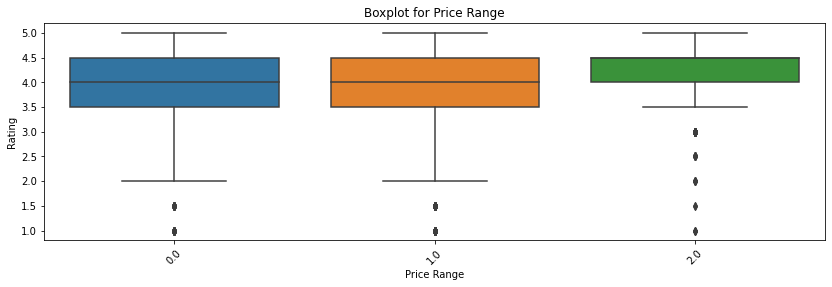

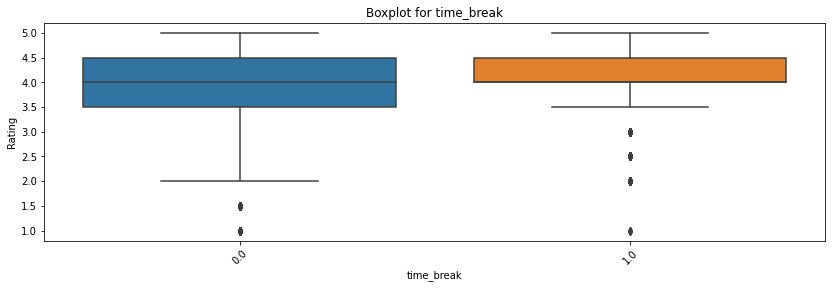

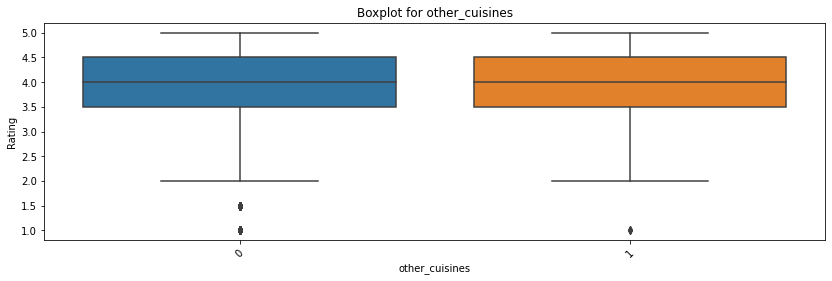

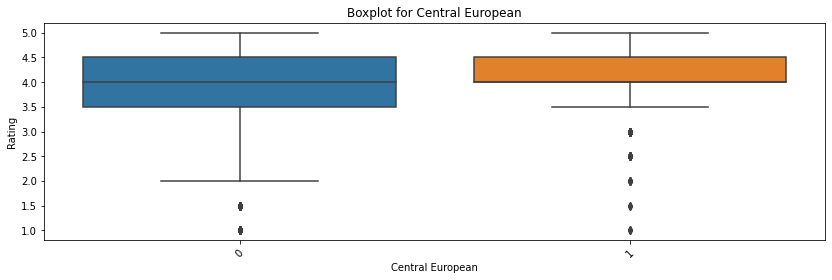

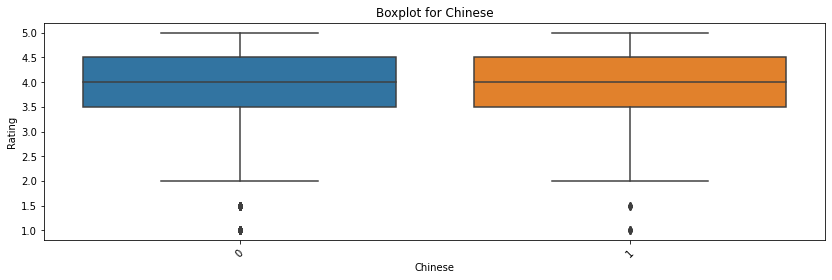

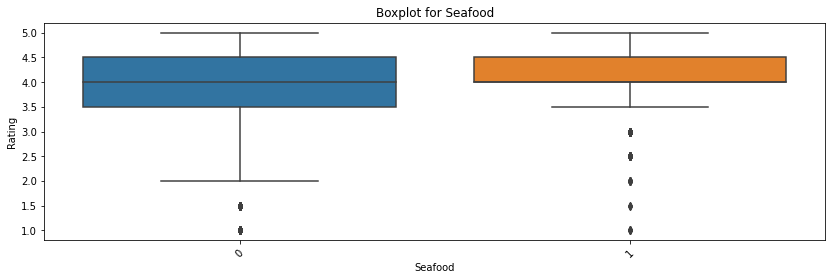

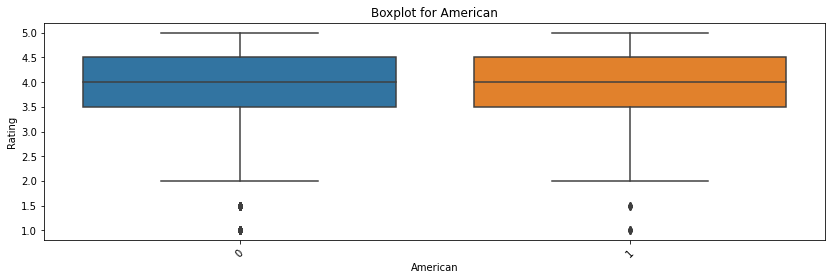

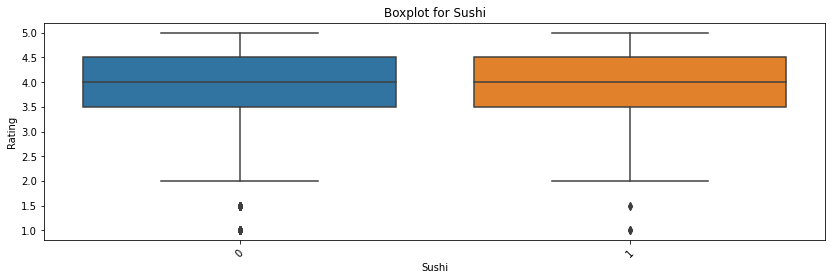

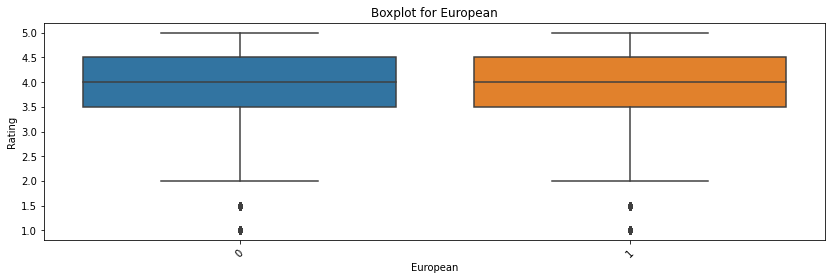

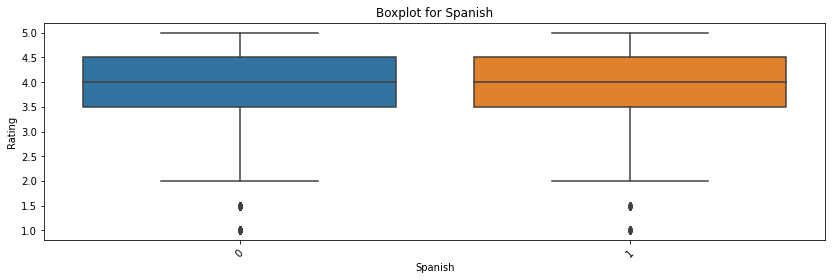

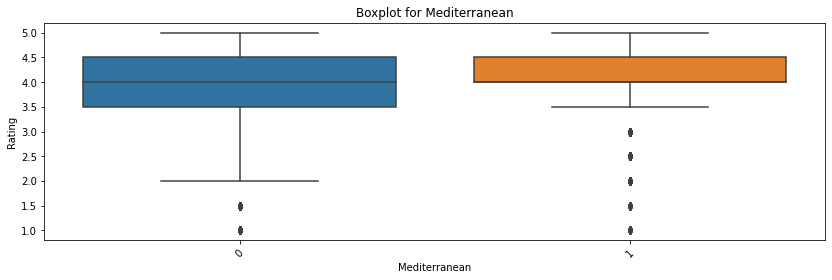

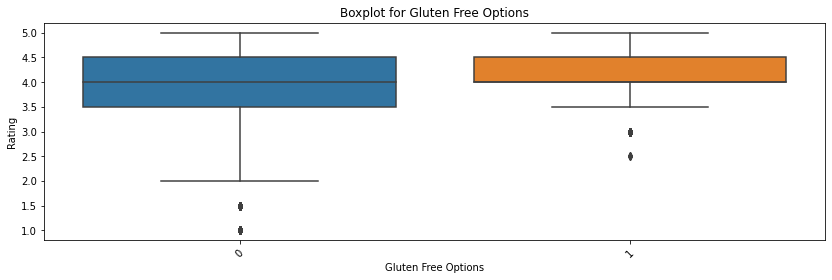

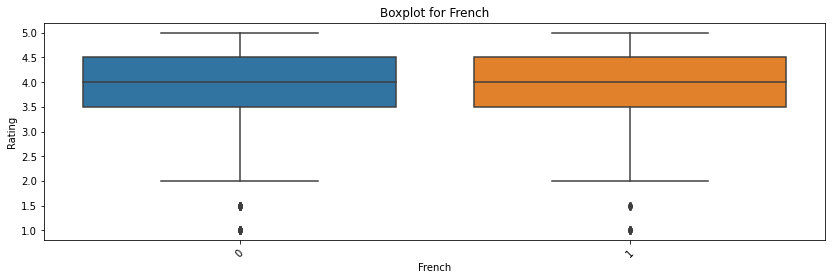

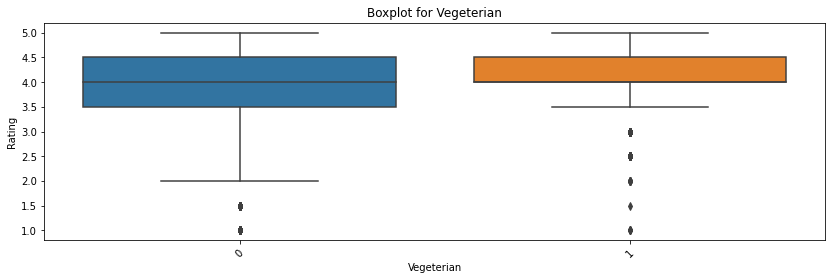

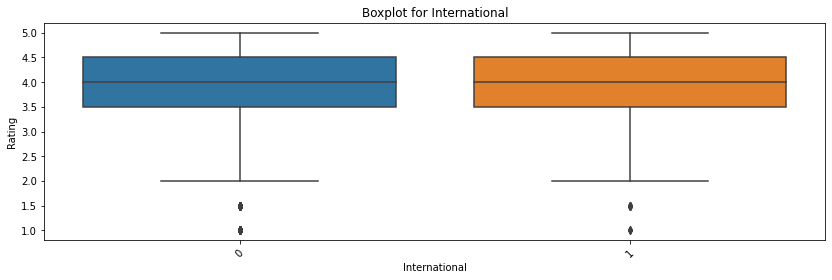

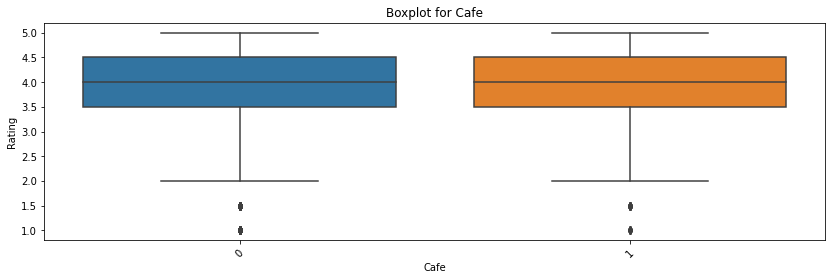

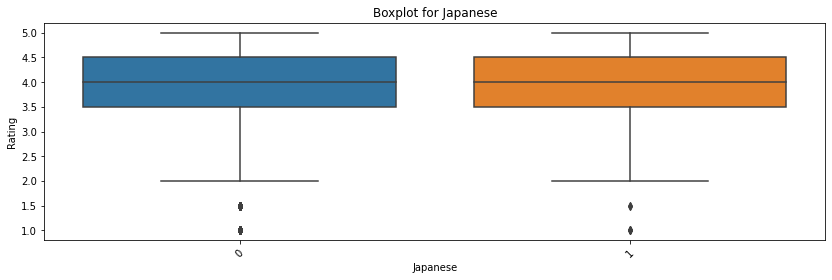

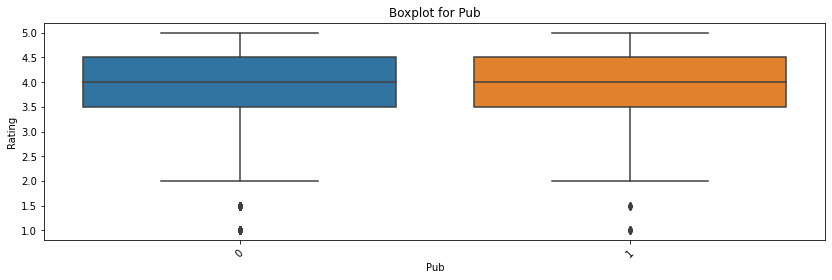

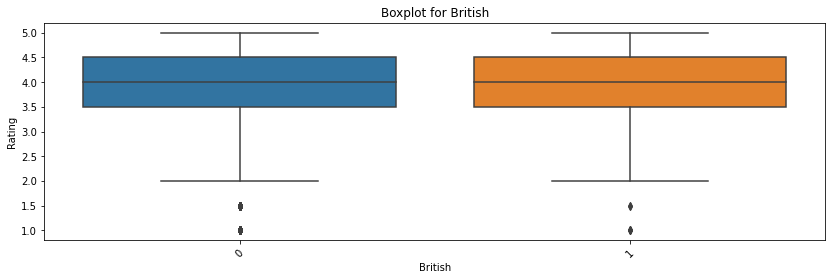

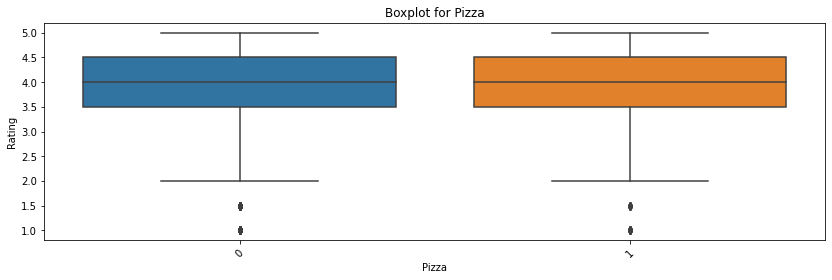

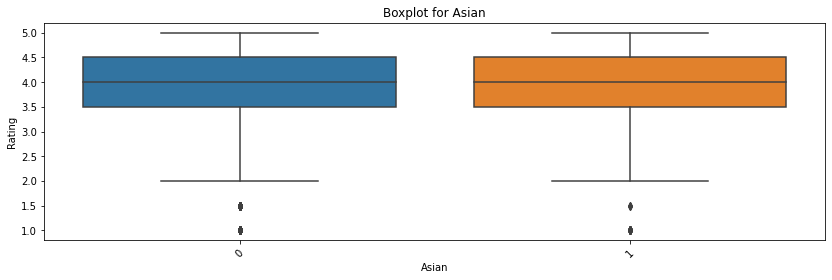

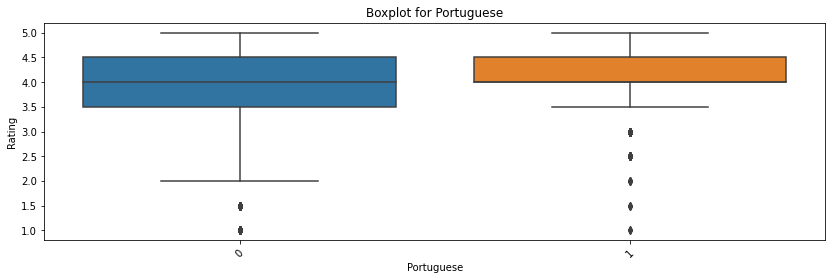

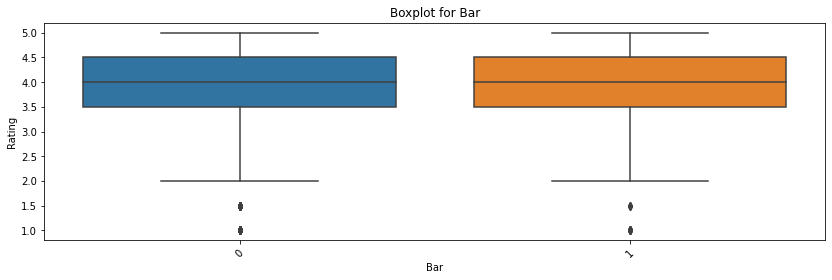

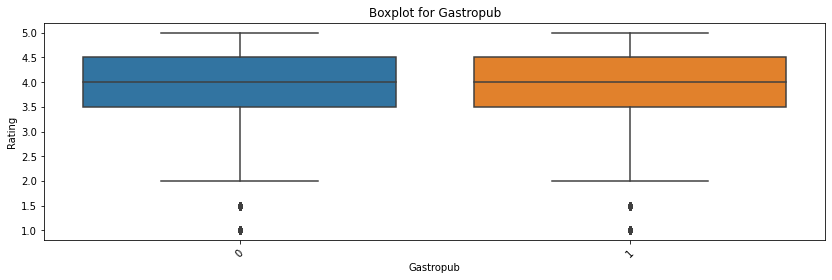

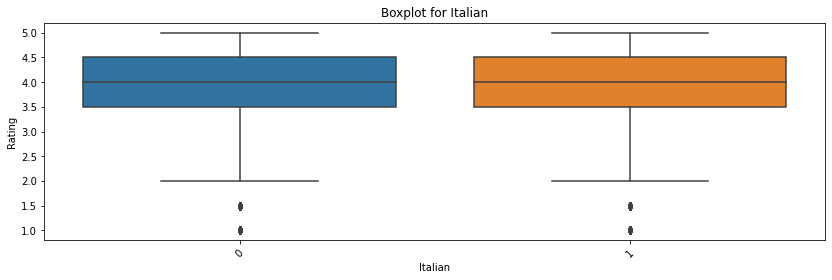

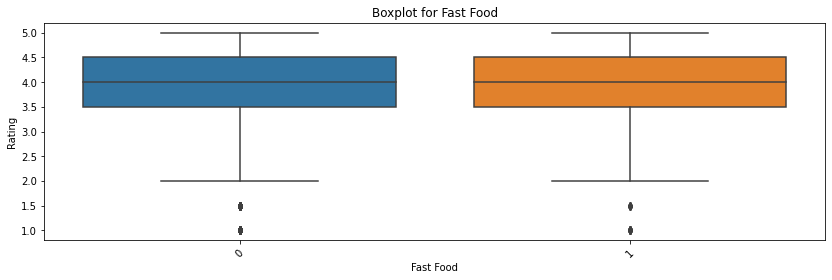

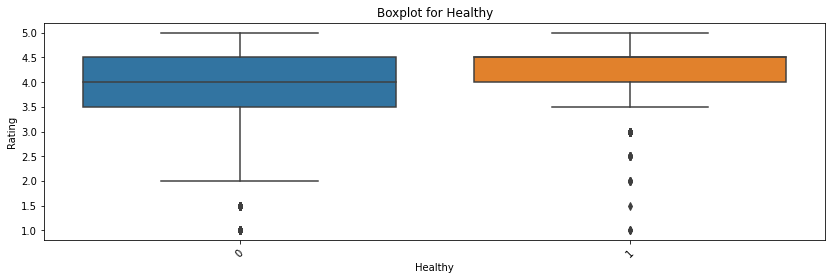

In [196]:

import matplotlib.pyplot as plt
import seaborn as sns
# Функция для построения коробчатых диаграм, чтобы не задавать одни и теже параметры для вывода каждого признака
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='Rating',
                data=df,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


# Перебираем все столбцы с числом уникальных значений меньше 5 в цикле
for col in df.columns:
    if len(df[col].unique())<5:
        get_boxplot(col)

При анализе получившихся коробчатых гистограмм не получается на глаз выявить достоврено влияющие на целевую переменную признаки. Поэтому проведем анализ статистически значимых различий

In [197]:
from itertools import combinations
from scipy.stats import ttest_ind

# Функция для попарного сравнения всех значений входящих в признак
def get_stat_dif(df, column):
    # Находим все возможные значения признака (из них отбираем 10 самх частых)
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    # Перебираем все комбинации по очереди в цикле и применяем к ним статистическую функцию
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'Rating'],
                     df.loc[df.loc[:, column] == comb[1], 'Rating']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            # Если есть статистические значимые различия, то выводим название стобца и завершаем цикл.
            print('Найдены статистически значимые различия для колонки', column)
            break
        
        
for col in df.columns:
    if len(df[col].unique())<5:
        get_stat_dif(df, col)

Найдены статистически значимые различия для колонки Price Range
Найдены статистически значимые различия для колонки time_break
Найдены статистически значимые различия для колонки Chinese
Найдены статистически значимые различия для колонки American
Найдены статистически значимые различия для колонки Sushi
Найдены статистически значимые различия для колонки European
Найдены статистически значимые различия для колонки Spanish
Найдены статистически значимые различия для колонки Mediterranean
Найдены статистически значимые различия для колонки Gluten Free Options
Найдены статистически значимые различия для колонки Vegeterian
Найдены статистически значимые различия для колонки International
Найдены статистически значимые различия для колонки Cafe
Найдены статистически значимые различия для колонки Pizza
Найдены статистически значимые различия для колонки Portuguese
Найдены статистически значимые различия для колонки Italian
Найдены статистически значимые различия для колонки Fast Food
Найден

Итак, не имеют статистической значимости следующие признаки: 
other_cuisines
Central European
Seafood
French
Japanese
Pub
British
Asian
Bar
Gastropub
Исключим их из модели в последующем

Последним шагом заполним оставшиеся пропуски в датасете

In [198]:
# Заполним оставшиеся пропуски
df.fillna(0,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39979
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  39980 non-null  float64
 1   Rating                   39980 non-null  float64
 2   Price Range              39980 non-null  float64
 3   Number of Reviews        39980 non-null  float64
 4   price_min                39980 non-null  float64
 5   price_max                39980 non-null  float64
 6   price_range              39980 non-null  float64
 7   work_hours               39980 non-null  float64
 8   time_break               39980 non-null  float64
 9   latitude                 39980 non-null  float64
 10  longitude                39980 non-null  float64
 11  rank                     39980 non-null  float64
 12  over_rank                39980 non-null  float64
 13  reviews_cnt              39980 non-null  float64
 14  latitude_city         

Итак у нас 29 признаков (47 за минусо 17 незначимых, плюс целевой) и 39980 записей без пропусков.
Присупаем к обучению и тестированию модели.

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [205]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
#X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
X = df.drop(['Rating','reviews_cnt','latitude_city','latitude_city', 'latitude', 'Ranking','area','price_range','other_cuisines',
'Central European','Seafood','French','Japanese','Pub','British','Asian','Bar','Gastropub',], axis = 1)
y = df['Rating']

In [200]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [206]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [202]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [207]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [208]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21730065032516258


Результат: Модель на основании подготовленных данных выдает среднюю абсолюную ошибку в размере 0,217, что меньше чем погрешность измерения рейтинга - 
шаг рейтинга 0,5 деленый пополам - 0,25.
Таким образом, обученную на обработанных данных модель можно использовать для предсказания рейтинга ресторана.